# Rede Neural Convolucional

Importe os pacotes necessários

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras import optimizers
import numpy as np
from numpy import array, dtype
import argparse
import random
import pickle
import cv2
import os
import livelossplot
import collections

Using TensorFlow backend.


In [2]:
dataset = 'dataset'

EPOCHS = 3
INIT_LR = 1e-3
MOMENTUM = 0.8
BS = 5
IMAGE_DIMS = (96, 96, 3)
modelname = 'blood.model'
label = 'lb.pickle'

data = []
labels = []

imagePaths = list(paths.list_images(dataset))

for imagePath in imagePaths:
    # carrega a imagem, pré-processa e armazena na lista de dados
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
 
    # extrai o rótulo da classe do caminho da imagem e atualiza a lista de rótulos
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, shuffle=False )

aug = ImageDataGenerator()
width=IMAGE_DIMS[1]
height=IMAGE_DIMS[0]
depth=IMAGE_DIMS[2]
classes=len(lb.classes_)

model = Sequential()
inputShape = (height, width, depth)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",
    input_shape=inputShape, use_bias=True))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))

#set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1))
model.add(BatchNormalization())

model.save_weights('my_model_weights.h5')

print('original')
print('#########################################################')
for layer in model.layers:
    weights = layer.get_weights()
#     print(weights)

# layer0 = layer[0].get_weights()
print(model.layers)
print(model.get_layer(Conv2D,0).get_weights())



print(model.get_layer(Conv2D,1).get_weights())
print(model.get_layer(Conv2D,2).get_weights())
print(model.get_layer(Conv2D,3).get_weights())
print(model.get_layer(Conv2D,4).get_weights())
print(model.get_layer(Conv2D,5).get_weights())
print(model.get_layer(Conv2D,6).get_weights())
print(model.get_layer(Conv2D,7).get_weights())
dense = model.get_layer(Conv2D,6).get_weights()
print(len(dense[0]))


model.summary()    

# Classificador
model.add(Dense(classes))
model.add(Activation("sigmoid")) #tanh <- Tangente hiperbólica
opt = optimizers.SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS, momentum=MOMENTUM, nesterov=True)
list2 = []
x1 = np.array([[[[ 0.0, 0.0, 0.0, 0.0,
          -0.01328568,  0.00467631,  0.08541586, -0.13332182,
          -0.07331081,  0.03104767,  0.11090994,  0.08136655,
           0.10363932,  0.0339255 , -0.11368597,  0.0401163 ,
           0.07737137, -0.08393481, -0.0754953 ,  0.1181816 ,
          -0.01975386,  0.06448592,  0.00372283,  0.01363812,
           0.09463756, -0.10887291, -0.0532052 , -0.03109502,
           0.086017  ,  0.11453049, -0.11710218, -0.05003399],
         [-0.08794098, -0.01197886,  0.0460287 ,  0.07030199,
          -0.09574483, -0.02729391,  0.09577692,  0.01589915,
          -0.12312776,  0.05501349, -0.06947199, -0.08073241,
           0.03513604, -0.09754799, -0.12017221,  0.061131  ,
           0.07886232,  0.08937377,  0.08561957, -0.11072384,
          -0.12718351, -0.06324843, -0.04101874,  0.00866956,
          -0.01848745,  0.11317103, -0.02872646, -0.04084659,
           0.02236558,  0.07640821,  0.02915251,  0.01860419],
         [-0.125615  ,  0.05804801,  0.04886501, -0.03731062,
          -0.03740104,  0.09487279, -0.05029335,  0.10246754,
           0.0758331 ,  0.11176014, -0.0946929 , -0.02960137,
           0.11750872,  0.09543149, -0.09066778, -0.08373393,
           0.02275251,  0.01726845, -0.00821178,  0.05300006,
           0.03919795, -0.03534307, -0.02553916,  0.07511923,
          -0.04353373, -0.00088049, -0.12128597,  0.13674767,
          -0.02109299,  0.10372095, -0.08446287,  0.02057062]],

        [[ 0.0908931 ,  0.12457402, -0.06967719,  0.03765889,
           0.1261399 , -0.10274535, -0.03858131,  0.07670672,
           0.10869962,  0.09054866,  0.01739083,  0.05030821,
          -0.06088652,  0.08500265,  0.07209067, -0.04025874,
          -0.11286565,  0.1190822 , -0.12370488, -0.05820951,
          -0.02132244, -0.03022002, -0.13069855, -0.04304111,
          -0.02690084, -0.03021073, -0.09844646, -0.06006057,
           0.01159091,  0.01872525, -0.08015039, -0.04080499],
         [ 0.0946981 ,  0.09598699,  0.11273198, -0.00506198,
           0.00444706, -0.05698169, -0.07600348,  0.13575624,
          -0.06887171,  0.07504134, -0.10105342, -0.11410034,
          -0.05096717,  0.1114253 , -0.00779727, -0.06990492,
          -0.05123637,  0.06684585,  0.08676793,  0.1090285 ,
          -0.01208317, -0.04665538,  0.03896798, -0.03139288,
           0.02185835,  0.08168378,  0.05443548, -0.10364875,
           0.06442192, -0.06531101, -0.12989083, -0.08005609],
         [-0.11809798,  0.07061429,  0.03967842, -0.00244315,
           0.06381193, -0.07973911,  0.12210913,  0.04742371,
          -0.00933245, -0.01920142,  0.02538155,  0.12924229,
           0.02608746, -0.12990163, -0.08818346,  0.03814954,
           0.12608837,  0.02343911, -0.02117374,  0.10146683,
          -0.08292858, -0.0153444 ,  0.03733678, -0.0224976 ,
          -0.09880321,  0.06629062, -0.00285931,  0.03041665,
          -0.1371999 ,  0.08240868, -0.12734593, -0.02232607]],

        [[ 0.03100206, -0.02455074, -0.10727534, -0.09077327,
           0.09132716,  0.07433465,  0.03962752,  0.07753059,
          -0.11201463, -0.06479663,  0.02960667,  0.08424076,
           0.0347525 ,  0.03018323, -0.10328947, -0.03719079,
          -0.03736393,  0.12125449, -0.13697806, -0.09366275,
          -0.08523176, -0.12169676,  0.13074209,  0.13008787,
          -0.04714122, -0.01647666,  0.0428316 , -0.08022478,
           0.03560527,  0.09375429,  0.02187741,  0.08420269],
         [-0.12679067, -0.10739277,  0.09756687,  0.06059258,
          -0.05483834, -0.00855248,  0.03745833, -0.09652218,
           0.07248187,  0.00161728,  0.06578855, -0.03695449,
           0.02786389, -0.07820068,  0.0579031 , -0.0156495 ,
          -0.12959489, -0.02312049, -0.10780333, -0.08297639,
          -0.09807197, -0.10893334, -0.03722698,  0.11180137,
           0.04124855,  0.10948917,  0.04201309, -0.10776489,
           0.04813857, -0.06688277,  0.0965212 , -0.10272825],
         [ 0.08529451,  0.11587144, -0.01367389,  0.00863568,
          -0.01408865,  0.06571804,  0.04204354, -0.10662207,
          -0.04566678, -0.03401448, -0.04575356, -0.09592894,
          -0.0835519 , -0.05857255, -0.02436399, -0.01262245,
          -0.10136048,  0.10362595, -0.11002596,  0.13601716,
          -0.05586931, -0.0530283 , -0.07681601,  0.10902768,
          -0.06995961, -0.04055521,  0.06830397, -0.01816501,
           0.04600871,  0.11051621, -0.05726299, -0.04165605]]],


       [[[-0.12026632,  0.05823369,  0.08538105,  0.03659688,
          -0.12480887,  0.03971195, -0.03274859,  0.09212148,
           0.04748534, -0.01935209,  0.13104053,  0.08985026,
           0.0605444 ,  0.07270516, -0.07184631,  0.00078557,
           0.02892843,  0.06012869, -0.10945766,  0.02157173,
           0.03103539,  0.09732555, -0.09778793,  0.11703928,
           0.04994147,  0.12211765, -0.12483428, -0.00151928,
          -0.07618334,  0.0163248 , -0.04166078, -0.06392479],
         [-0.07984602,  0.06193858, -0.11130609, -0.11268276,
          -0.08532669, -0.04714991,  0.06660074,  0.03958517,
           0.1309921 , -0.1288565 , -0.05178937, -0.11789852,
           0.00296861,  0.12007309, -0.01375655, -0.12546515,
           0.11301859, -0.02038037,  0.03941719,  0.05740824,
          -0.10625196, -0.08231336,  0.105514  ,  0.00349677,
           0.02895506, -0.02772494,  0.03886025, -0.04571085,
          -0.06530005,  0.13057818,  0.03815569, -0.00033382],
         [ 0.07266554, -0.04525024,  0.00492649,  0.13610615,
           0.00262229,  0.00773501, -0.00754674,  0.03360945,
          -0.02959963, -0.0603627 , -0.10755269, -0.05193464,
          -0.06619351, -0.09419104, -0.07500321,  0.04751143,
           0.08249095, -0.04349424,  0.11666848, -0.0720416 ,
          -0.09474209,  0.07052557, -0.02535114, -0.03985529,
           0.08348536,  0.11734079,  0.06153679, -0.08064847,
          -0.03291111, -0.06414381, -0.07232215,  0.05503036]],

        [[-0.064119  , -0.01195642, -0.12486619,  0.08181077,
           0.09779839,  0.04544395, -0.09055945,  0.09885195,
          -0.01300365,  0.05095342, -0.10184149,  0.03575201,
           0.0857309 ,  0.04913174, -0.02144089, -0.10129096,
           0.02000213, -0.01282352, -0.05812849, -0.13777933,
           0.07431358, -0.11057392,  0.0102945 , -0.08887571,
           0.04175995, -0.01997488, -0.03532235,  0.09597853,
           0.00592867,  0.1231869 , -0.08409305,  0.05980122],
         [ 0.00128715, -0.04709348,  0.0194058 ,  0.02334404,
           0.1268465 ,  0.05709739, -0.13551688,  0.08684906,
          -0.04259018,  0.13622575,  0.05290787,  0.07464579,
          -0.03364488,  0.07799785,  0.01728912, -0.11157581,
          -0.11726954,  0.03264625,  0.11995642, -0.07337218,
          -0.07260332,  0.04020441, -0.04573793, -0.05265848,
           0.13383828,  0.05660658,  0.05852355, -0.01263328,
           0.06517537, -0.13622898,  0.01194218,  0.03142713],
         [ 0.08736791,  0.13341315, -0.01982263,  0.06089613,
          -0.08139857, -0.07527816,  0.12678148, -0.10166633,
          -0.12143628, -0.11368248, -0.07870962, -0.05004797,
           0.05375935, -0.02201989, -0.01393147, -0.09892996,
          -0.12096703, -0.06651177, -0.13016477,  0.09431644,
          -0.05405629,  0.08431651,  0.0116861 , -0.06292399,
          -0.02090892,  0.02756093,  0.09874187,  0.10395487,
          -0.01258171,  0.09392448, -0.0375528 ,  0.096462  ]],

        [[-0.09808198,  0.10786466,  0.12506042,  0.02957919,
           0.04878861, -0.07282037, -0.04027499,  0.10545766,
          -0.10739093, -0.09799517, -0.11871564,  0.11519597,
          -0.07839119, -0.09031592, -0.00750104,  0.06055595,
           0.06102933,  0.09214038,  0.05909327,  0.04872289,
          -0.02323934, -0.09065274,  0.10507877,  0.12025301,
           0.06498636,  0.08130163, -0.06243469, -0.09490626,
           0.0282477 ,  0.08196865, -0.09649128,  0.01297322],
         [ 0.12693222, -0.01670002,  0.04145496,  0.05226837,
           0.10333952,  0.01447847,  0.00559765, -0.05383829,
           0.05331658,  0.01672493,  0.0610908 , -0.01746766,
          -0.08166444,  0.00031339,  0.12577118,  0.08398923,
          -0.07515263, -0.07681814,  0.097499  ,  0.00039588,
          -0.10244401,  0.05151932,  0.04077815,  0.05088498,
          -0.0942501 ,  0.02918288, -0.07260444,  0.03311357,
           0.08082737, -0.07226858,  0.11696576,  0.08163285],
         [-0.07028965,  0.0073909 , -0.01268552, -0.03344779,
          -0.1220981 ,  0.00500266,  0.05715984,  0.04108696,
          -0.03524568,  0.00736286,  0.04393303,  0.04646224,
           0.05263466, -0.09842971, -0.08621585,  0.12373097,
          -0.07774106,  0.11245324, -0.12031907, -0.11487581,
           0.03386649, -0.01429201, -0.08459195, -0.12533075,
          -0.0593285 ,  0.08959073,  0.11475103,  0.08270232,
           0.04605082, -0.11828916, -0.02110941,  0.11609827]]],


       [[[-0.12565008, -0.09291098, -0.10730968, -0.08572575,
           0.02245314, -0.03175016,  0.04912443,  0.08854561,
          -0.10070775,  0.10775371,  0.05456516, -0.03931197,
           0.08210807,  0.06357744, -0.04752177,  0.03252111,
          -0.08609594,  0.12330796,  0.06280458, -0.0795911 ,
          -0.12202521,  0.01650512, -0.03261335, -0.05357574,
           0.03564607,  0.06194705, -0.08094671, -0.00224102,
          -0.00793403, -0.00226672,  0.00747032, -0.003205  ],
         [ 0.12415718,  0.10967268, -0.10950013,  0.07297656,
          -0.11098707, -0.0805774 , -0.06846172,  0.11537848,
          -0.05783557, -0.09930028,  0.12076928,  0.10702306,
           0.07908161, -0.02663973, -0.0010137 , -0.03553949,
           0.08257914,  0.03692047,  0.13713084, -0.05462685,
          -0.13004832,  0.06333889,  0.09135249, -0.02604613,
          -0.12334875,  0.0338591 , -0.02735011, -0.10865849,
           0.07033272,  0.0229201 ,  0.1171938 ,  0.12785612],
         [ 0.10467036, -0.13798852,  0.00697874,  0.07789867,
          -0.07515858, -0.05238923,  0.06731008,  0.12413023,
          -0.07740701, -0.12686032,  0.1352004 , -0.09826759,
          -0.06722334,  0.08124912, -0.05652859, -0.09211279,
           0.01053539,  0.12775789,  0.11297084, -0.02483836,
          -0.12561998,  0.12535374,  0.07428408, -0.11193526,
          -0.05807088, -0.08030728, -0.1256587 , -0.04106076,
           0.11948936, -0.13195042,  0.05302376,  0.05172001]],

        [[ 0.05610919,  0.07770184,  0.08875008,  0.0928347 ,
           0.09467141, -0.11401508, -0.05315581, -0.13528882,
          -0.10241561, -0.09030023, -0.12257351, -0.08487158,
           0.00481796,  0.02744916, -0.05014192, -0.03434987,
          -0.07753982, -0.04737195,  0.05735435, -0.06331091,
           0.01535705,  0.06228004,  0.10494344,  0.09907484,
           0.0626514 ,  0.06030288,  0.12594767,  0.01903038,
          -0.00049897, -0.04332992,  0.05449814, -0.0060385 ],
         [ 0.02952445,  0.07154059,  0.00045204, -0.06676885,
           0.04871927, -0.07091461, -0.00621887,  0.09368104,
           0.00469777,  0.05065376, -0.08022893, -0.01619644,
          -0.09849434, -0.06345925, -0.1165483 , -0.07704617,
           0.09676012,  0.07064801,  0.10125634,  0.03504686,
          -0.01377027, -0.06024346, -0.06463024,  0.12979285,
           0.01815188, -0.13019879, -0.09359618, -0.09764223,
           0.00810832, -0.04778626,  0.12247752, -0.12090997],
         [-0.00875573,  0.11842327,  0.1349086 , -0.00434315,
           0.09066741,  0.10474387,  0.11735506,  0.09553289,
           0.1356812 ,  0.10601716,  0.08527575,  0.0239386 ,
           0.09640698, -0.11322839, -0.05304077, -0.11158732,
          -0.09488714, -0.00682378, -0.12393703,  0.11549817,
           0.09732565, -0.05217583,  0.02901688, -0.01937667,
           0.09284003,  0.13327114,  0.11991735,  0.08207348,
           0.03525245, -0.0494772 , -0.0783522 , -0.05356038]],

        [[-0.08822709,  0.03276445,  0.07977609, -0.11818798,
          -0.10289968,  0.09008707,  0.00184573,  0.12535714,
          -0.09333169,  0.12546347,  0.081637  ,  0.09713471,
          -0.12041488, -0.05058383, -0.01900682,  0.12645923,
           0.04387328,  0.04949425,  0.04212457, -0.06703108,
           0.04990165, -0.1290458 , -0.06409211, -0.06907013,
          -0.0933031 ,  0.05217047,  0.10062914,  0.04261923,
          -0.00254114, -0.00577734, -0.0211767 , -0.13331155],
         [ 0.00954857, -0.13287038,  0.00262156, -0.01215954,
          -0.10440271, -0.0249042 , -0.04890509,  0.04052158,
          -0.03889371, -0.10527448, -0.03524078, -0.04938599,
          -0.11657479, -0.12387615,  0.0820201 , -0.00027068,
           0.05880338, -0.05532849,  0.00900787, -0.09549384,
          -0.06981279, -0.12706888, -0.06557333, -0.03979702,
          -0.02177089,  0.09939748, -0.08489853,  0.13300247,
           0.12660469, -0.12880458,  0.02211525, -0.09809701],
         [ 0.08145046, -0.10838012,  0.062838  ,  0.0326858 ,
           0.0858077 , -0.09309421, -0.13121891,  0.0726041 ,
           0.07681476,  0.08603977, -0.00753465,  0.11388819,
          -0.13529089, -0.09719884,  0.06588049, -0.07574732,
          -0.00695892, -0.11985826,  0.10207209,  0.09968928,
          -0.09637687, -0.03485865,  0.11063029, -0.06006024,
           0.13390951,  0.03697339,  0.03828865,  0.102038  ,
          -0.03760052, -0.076601  , -0.12021347,  0.04045153]]]],
      dtype='float32')
x2 = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype='float32')
x3 = np.zeros(32, dtype='float32')
list2.append(x1)
list2.append(x2)
model.get_layer(Conv2D,1).set_weights(list2)
print(model.get_layer(Conv2D,1).get_weights())
print('densa')
print(model.get_layer(Dense,8).get_weights())   
# for layer in model.layers:
#     weights2 = layer.get_weights()
#     print(weights2)
    
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] data matrix: 10.37MB
original
#########################################################
[<keras.layers.convolutional.Conv2D object at 0x7f4b95514390>, <keras.layers.core.Activation object at 0x7f4bc9426630>, <keras.layers.normalization.BatchNormalization object at 0x7f4b954e2eb8>, <keras.layers.pooling.MaxPooling2D object at 0x7f4b95514860>, <keras.layers.core.Flatten object at 0x7f4b95514cc0>, <keras.layers.core.Dense object at 0x7f4b95471a90>, <keras.layers.normalization.BatchNormalization object at 0x7f4b953b8cc0>]
[]
[array([[[[ 1.24964491e-01,  1.12796381e-01,  1.23791769e-01,
          -5.63618317e-02,  2.87158638e-02,  1.37248740e-01,
          -9.51339602e-02,  1.05019704e-01, -1.33463278e-01,
          -1.27668634e-01, -3.38038802e-03,  7.90427774e-02,
           7.86206126e-02, -1.30052656e-01,  8.06772560e-02,
          -1.08588375e-01,  3.88912708e-02, -6.99151233e-02,
          -6.46177977e-02,  7.64434189e-02,  8.15819800e-02,
          -6.61008582e-02, -6.83468431

In [3]:
plot_losses = livelossplot.PlotLossesKeras()

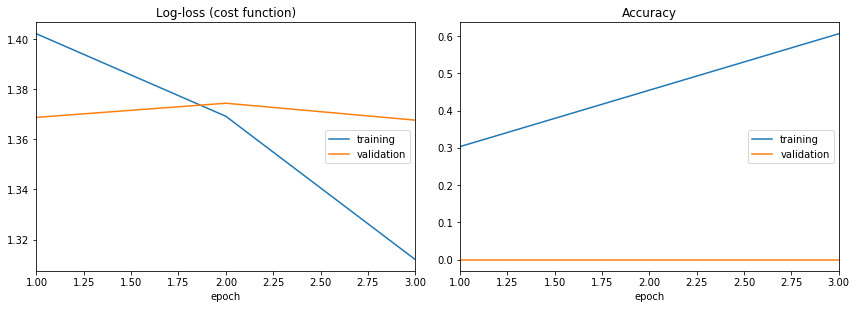

In [4]:
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
    callbacks=[plot_losses],
    verbose=1
)

In [5]:
train_loss = H.history["loss"]
val_loss = H.history["val_loss"]
train_acc = H.history["acc"]
val_acc = H.history["val_acc"]

[1.402084318074313, 1.369179747321389, 1.312023780562661]
[1.3687336444854736, 1.3743774890899658, 1.3676429986953735]
[0.30303030799735675, 0.454545464479562, 0.6060606178009149]
[0.0, 0.0, 0.0]


In [ ]:
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)

Salva a rede no disco

In [6]:
print("[INFO] serializing network...")
model.save(modelname)

[INFO] serializing network...


Salva os rótulos binários no disco

In [7]:
print("[INFO] serializing label binarizer...")
f = open(label, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing label binarizer...


Traça a perda e a precisão do treinamento